In [1]:
import uproot
import awkward as ak
import numpy as np
import vector
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.metrics import r2_score

In [2]:
# Open LHE file
with uproot.open("../madgraph/hard_process.root:events") as f:
    #print(f.keys())
    px = f['px'].array()
    py = f['py'].array()
    pz = f['pz'].array()
    e = f['energy'].array()
    m = f['mass'].array()
    pid = f['pid'].array()
    m1 = f['mother1'].array()
    m2 = f['mother2'].array()

# Extract top quark 3-Vector based on PID
mask = pid==6
top_px = px[mask]
top_py = py[mask]
top_pz = pz[mask]

In [3]:
# Open Pythia file
with uproot.open("dataset.root:fastjet") as f:
    #print(f.keys())
    jet_pt = f['jet_pt'].array()
    jet_eta = f['jet_eta'].array()
    jet_phi = f['jet_phi'].array()
    trk_pt = f['trk_pt'].array()
    trk_origin = f['trk_origin'].array()

# Initialize Masks
event_mask = np.zeros(len(jet_pt)).tolist()
jet_mask = ak.zeros_like(jet_pt).to_list()

In [4]:
# Initialize lists for plotting
pt_partons = []
pt_fat_jets = []
deltaR = []
deltaEta = []
deltaPhi = []

unweighted_origins = []
weighted_origins = []

missing_jet=0
cutflow_deltaR=0

# Loop over all events
num_events=len(jet_pt)
for i in range(num_events):

    #if i%100==0:
    #    print("\tProcessing: ", i, " / ", len(jet_pt), end="\r")

    # Ensure only one top quark
    assert len(top_px[i])==1

    # Ensure at least one fat jet
    if len(jet_pt[i])<1:
        missing_jet+=1
        continue

    # Save parton 3-Vector
    parton = vector.MomentumObject3D(px=top_px[i][0], py=top_py[i][0], pz=top_pz[i][0])

    # Find closest fat jet in deltaR
    delR = []
    for j in range(len(jet_pt[i])):
        delR.append(parton.deltaR(vector.MomentumObject3D(pt=jet_pt[i][j], eta=jet_eta[i][j], phi=jet_phi[i][j])))
    argmin = np.argmin(delR)

    candidate = vector.MomentumObject3D(pt=jet_pt[i][argmin], eta=jet_eta[i][argmin], phi=jet_phi[i][argmin])
    #if abs(parton.deltaphi(candidate))>1.5:
    #    continue
    #if abs(parton.deltaeta(candidate))>2:
    #    continue
    if abs(parton.deltaR(candidate))>1.0:
        cutflow_deltaR+=1
        continue

    # Closest jet in deltaR to parton is matched jet
    matched_jet = candidate

    # Fill lists for plotting
    pt_partons.append(parton.pt)
    pt_fat_jets.append(matched_jet.pt)
    deltaR.append(parton.deltaR(matched_jet))
    deltaEta.append(parton.deltaeta(matched_jet))
    deltaPhi.append(parton.deltaphi(matched_jet))
    
    # Calculate Truth Origins
    weights = trk_pt[i][argmin]
    origins = trk_origin[i][argmin]
    
    fromTop = origins==6 
    fromW = origins==24
    fromHadronic=fromTop|fromW
    
    unweighted = ak.mean(fromHadronic,axis=0)
    weighted = ak.mean(fromHadronic,axis=0,weight=weights)
    
    unweighted_origins.append(unweighted)
    weighted_origins.append(weighted)
    
print("\tEvents without reco jet: ", missing_jet, "/", num_events)
print("\tDeltaR Cutflow: ", cutflow_deltaR, "/", num_events)
print()

	Events without reco jet:  4846 / 10000
	DeltaR Cutflow:  661 / 10000



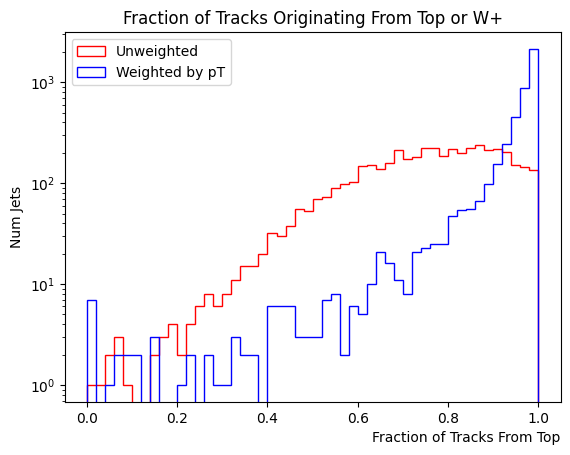

In [5]:
plt.title("Fraction of Tracks Originating From Top or W+")
plt.hist(unweighted_origins,bins=50,range=(0,1),color='r',histtype='step',label="Unweighted")
plt.hist(weighted_origins,bins=50,range=(0,1),color='b',histtype='step',label="Weighted by pT")
plt.yscale('log')
plt.ylabel('Num Jets')
plt.xlabel('Fraction of Tracks From Top',loc='right')
plt.legend()
plt.show()

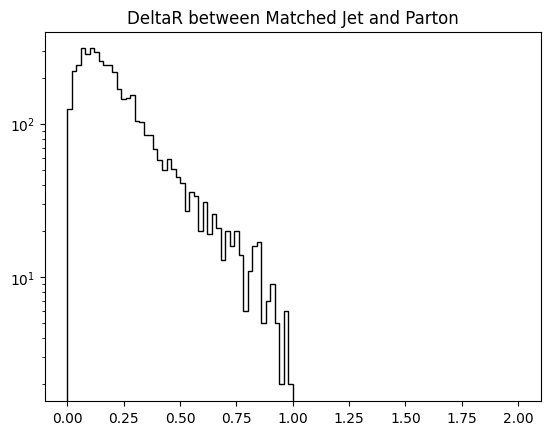

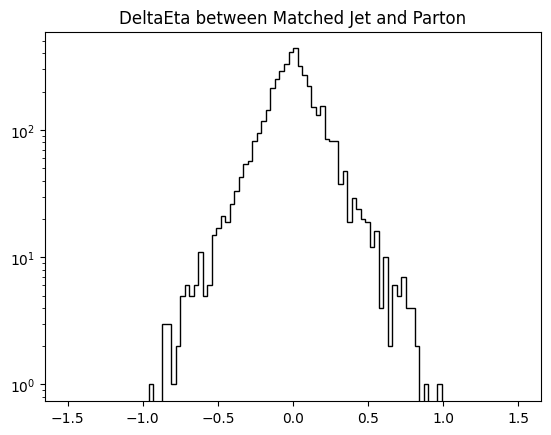

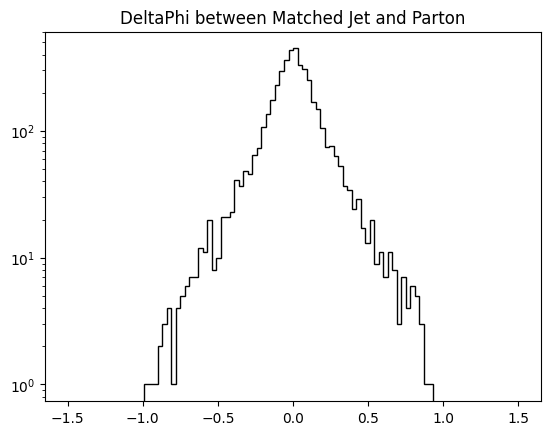

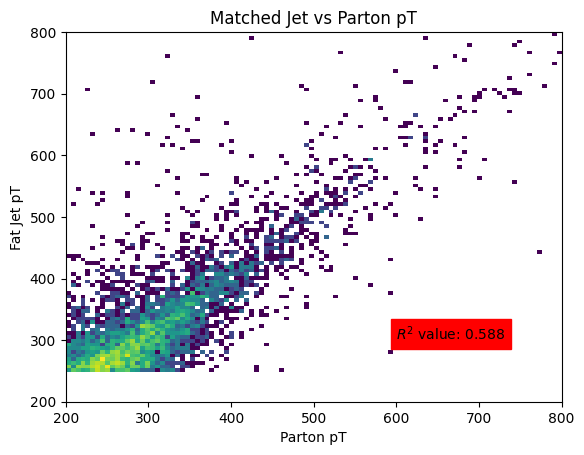

In [6]:
#fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
fig3, ax3 = plt.subplots()
fig4, ax4 = plt.subplots()
    
fig1, ax1 = plt.subplots()
ax1.set_title("Matched Jet vs Parton pT")
ax1.hist2d(pt_partons,pt_fat_jets, bins=100,norm=mcolors.LogNorm(),range=((200,800),(200,800)))
ax1.set_xlabel("Parton pT")
ax1.set_ylabel("Fat Jet pT")
ax1.text(600,300,"$R^2$ value: "+str(round(r2_score(pt_partons,pt_fat_jets),3)),backgroundcolor='r',color='k')

ax2.set_title("DeltaR between Matched Jet and Parton")
ax2.hist(deltaR,histtype='step',bins=100,range=(0,2),color='k')
ax2.set_yscale("log")
#ax2.legend()

ax3.set_title("DeltaEta between Matched Jet and Parton")
ax3.hist(deltaEta,histtype='step',bins=100,range=(-1.5,1.5),color='k')
ax3.set_yscale("log")
#ax3.legend()

ax4.set_title("DeltaPhi between Matched Jet and Parton")
ax4.hist(deltaPhi,histtype='step',bins=100,range=(-1.5,1.5),color='k')
ax4.set_yscale("log")
#ax4.legend()
    
plt.show()